In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import tensorflow as tf
import tensorflow.data as tfdata

sys.path.append("../../")

from model.tf.hydro.gr4j_prod import ProductionStorage
from model.tf.ml import ConvNet
from utils.training import EarlyStopper
from utils.evaluation import evaluate
from data.tf.utils import read_dataset_from_file, get_station_list

2024-08-20 14:45:10.579448: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 14:45:10.903642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 14:45:10.920439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 14:45:10.925528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 14:45:10.937741: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_dir = '../../data/camels/aus/'
sub_dir = 'no-scale-seq'
station_id = '318076'
run_dir = '../../results/qdeepgr4j-lstm-tf'

window_size = 10

In [3]:
print(f"Reading data for station_id: {station_id}")
train_ds, val_ds = read_dataset_from_file(data_dir, 
                                          sub_dir, 
                                          station_id=station_id)

Reading data for station_id: 318076


2024-08-20 14:49:17.680499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 459 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [4]:
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

plot_dir = os.path.join(run_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

t_train, X_train, y_train = train_ds._tensors
t_val, X_val, y_val = val_ds._tensors

y_mu = y_train.numpy().mean(axis=0)
y_sigma = y_train.numpy().std(axis=0)

In [5]:
X_train = tf.keras.ops.nan_to_num(X_train)
X_val = tf.keras.ops.nan_to_num(X_val)


y_train = (y_train - y_mu)/y_sigma
y_val = (y_val - y_mu)/y_sigma


In [6]:
prod_store = ProductionStorage(x1=530.9270033037365)
inp_train = prod_store(X_train, include_x=True)[0]

In [7]:
def create_sequence(X, y, window_size):

        assert window_size is not None, "Window size cannot be NoneType."

        # Create empyty sequences
        Xs, ys = [], []

        # Add sequences to Xs and ys
        for i in range(1, len(X) - window_size):
            Xs.append(tf.concat([
                                    X[i: (i + window_size)], 
                                    y[i-1: (i + window_size - 1)]
                                ], axis=1)
                    )
            ys.append(y[i + window_size - 1])

        Xs, ys = tf.stack(Xs), tf.stack(ys)
        # Xs = torch.unsqueeze(Xs, dim=1)

        return Xs, ys

In [8]:
X_train_seq, y_train_seq = create_sequence(inp_train, y_train, 
                                           window_size=window_size)
X_train_seq = X_train_seq[..., None]
X_train_seq.shape, y_train_seq.shape

(TensorShape([7436, 10, 10, 1]), TensorShape([7436, 1]))

In [9]:
inp_val = prod_store(X_val, include_x=True)[0]
X_val_seq, y_val_seq = create_sequence(inp_val, y_val, 
                                       window_size=window_size)
X_val_seq = X_val_seq[..., None]
X_val_seq.shape, y_val_seq.shape

(TensorShape([3181, 10, 10, 1]), TensorShape([3181, 1]))

In [10]:
train_ds = tfdata.Dataset.from_tensor_slices((X_train_seq, y_train_seq))
train_dl = train_ds.shuffle(buffer_size=1024).batch(batch_size=256)

val_ds = tfdata.Dataset.from_tensor_slices((X_val_seq, y_val_seq))
val_dl = val_ds.shuffle(buffer_size=1024).batch(batch_size=256)

In [11]:
in_channels = 1
n_features = 10
n_filters = (16, 16, 8)
dropout = 0.1

n_epoch = 400
lr = 5e-4

quantiles = [0.05, 0.50, 0.95]
n_quantiles = len(quantiles)

In [12]:
def tilted_loss(y, f):
    for i, q in enumerate(quantiles):
        e = y[:, 0] - f[:, i]
        if i == 0:
            l = tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))
        else:
            l += tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))
    return l

Epoch 1/400


I0000 00:00:1724129405.951555 2647504 service.cc:146] XLA service 0x14cc70004d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724129405.951582 2647504 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-08-20 14:50:05.980147: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-20 14:50:06.119629: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/21 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.8207

I0000 00:00:1724129406.844830 2647504 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.7283 - val_loss: 0.4307
Epoch 2/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4397 - val_loss: 0.3480
Epoch 3/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3585 - val_loss: 0.3038
Epoch 4/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3031 - val_loss: 0.2861
Epoch 5/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2918 - val_loss: 0.2733
Epoch 6/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2968 - val_loss: 0.2591
Epoch 7/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2584 - val_loss: 0.2611
Epoch 8/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2455 - val_loss: 0.2513
Epoch 9/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2286 - val_loss: 0.2421
Epoch 10/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2317 - val_loss: 0.2439
Epoch 11/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2365 - val_loss: 0.2505
Epoch 12/400
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2228 - val_l

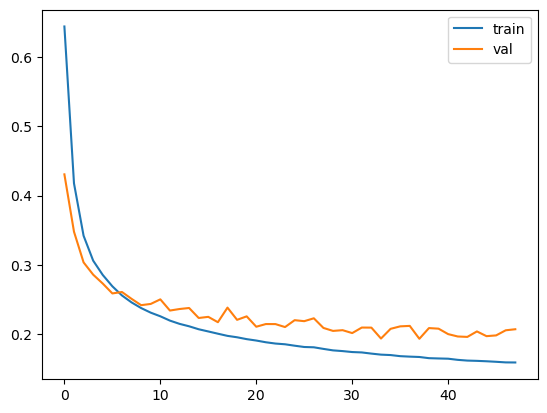

In [13]:
# Compile the model with the Adam optimizer and custom loss function
model = ConvNet(n_ts=window_size, 
                n_features=n_features,
                n_channels=in_channels,
                out_dim=n_quantiles,
                n_filters=n_filters,
                dropout_p=dropout)

model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.99, weight_decay=0.02),
              loss=tilted_loss)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10)

# Train the model
hist_ = model.fit(X_train_seq, y_train_seq, batch_size=256, shuffle=True, 
          validation_split=0.3, epochs=n_epoch, callbacks=[callback])


# Plot the loss
fig, ax = plt.subplots()
epochs = np.arange(len(hist_.history['loss']))
ax.plot(epochs, hist_.history['loss'], label='train')
ax.plot(epochs, hist_.history['val_loss'], label='val')
plt.legend()

In [14]:
def evaluate_preds(model, ds, batch_size, x_scaler=None, y_scaler=None, quantiles=[0.5]):
    # Empty list to store batch-wise tensors
    P = []
    ET = []
    Q = []
    Q_hat = []

    # Create a batched dataset
    ds_batched = ds.batch(batch_size)

    for X, y in ds_batched:
        # Predict using the model
        y_hat = model(X) * y_sigma + y_mu
        y = y * y_sigma + y_mu

        # Append predictions and true values to the lists
        Q.append(y.numpy())
        Q_hat.append(y_hat.numpy())

        X_inv = X[:, -1, :-1].numpy()
        
        P.append(X_inv[:, 0])
        ET.append(X_inv[:, 1])
    
    # Concatenate all batches
    P = np.concatenate(P, axis=0)
    ET = np.concatenate(ET, axis=0)
    Q = np.concatenate(Q, axis=0).flatten()
    Q_hat = np.concatenate(Q_hat, axis=0)
    Q_hat = np.clip(Q_hat, 0, None)

    return evaluate(P, ET, Q, Q_hat, quantiles=quantiles)

W0000 00:00:1724129411.581739 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129411.594617 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129411.594906 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129411.595163 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129411.595421 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129411.595680 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129411.595934 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129411.596202 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129411.596525 2646221 gp

(0.723085880279541, 0.7831380235805672, <Figure size 1600x600 with 1 Axes>)

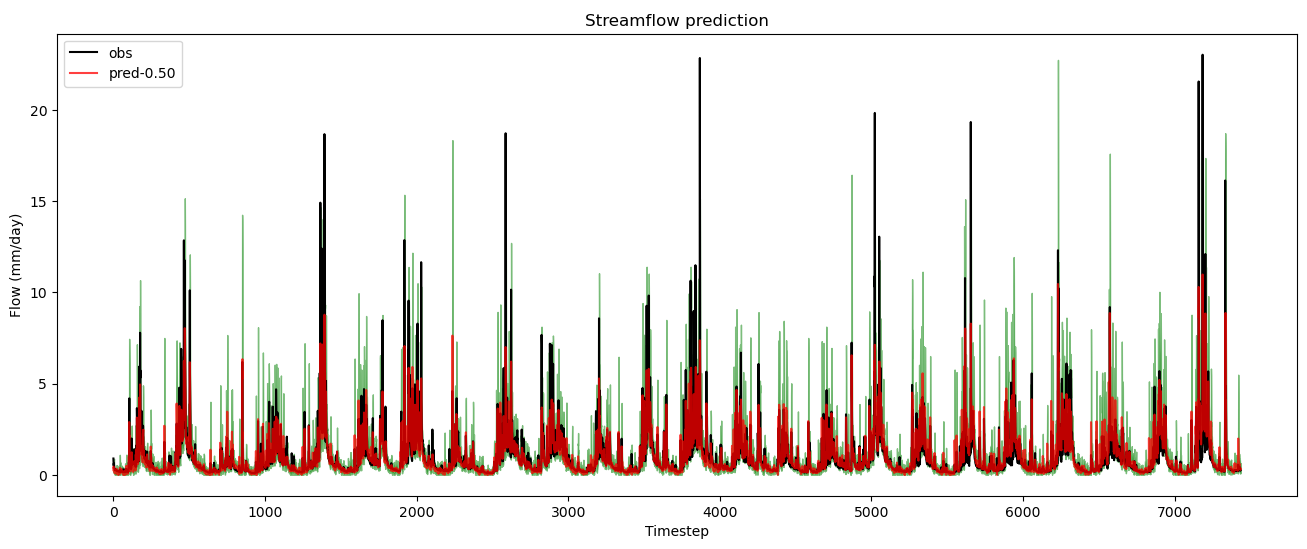

In [15]:
evaluate_preds(model, train_ds, batch_size=256, quantiles=quantiles)

W0000 00:00:1724129412.205320 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129412.205666 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129412.205925 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129412.206180 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129412.206426 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129412.206679 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129412.206930 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129412.207204 2646221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724129412.207474 2646221 gp

(0.6561028957366943, 0.7441045871947002, <Figure size 1600x600 with 1 Axes>)

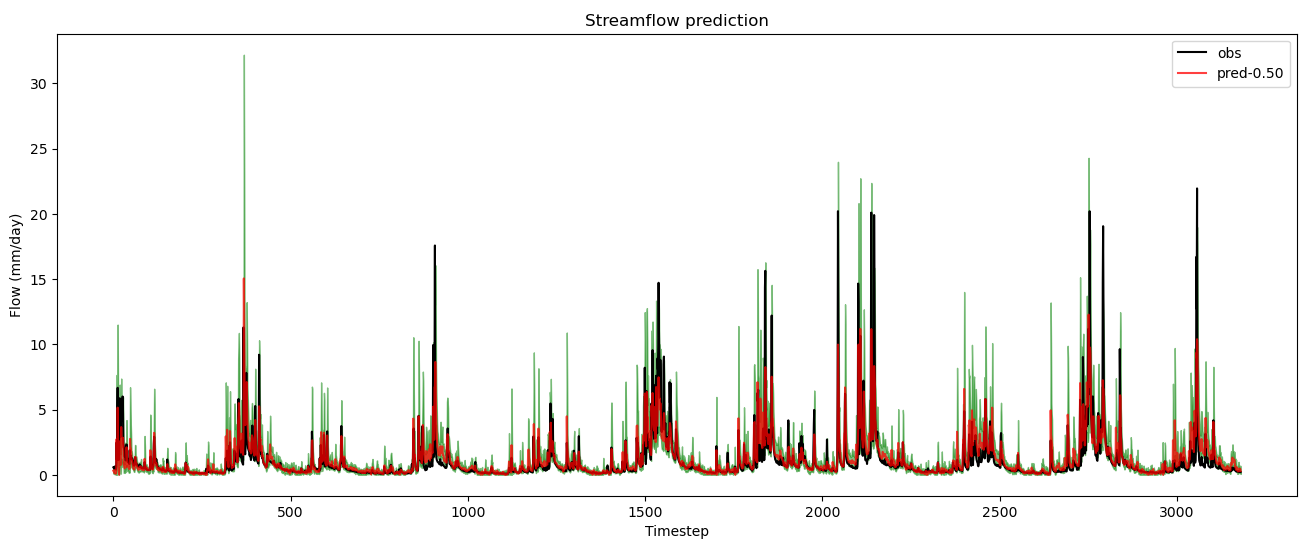

In [16]:
evaluate_preds(model, val_ds, batch_size=256, quantiles=quantiles)